In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount='True')


Mounted at /content/drive


In [2]:
cd ..

/


In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import  plot_model ,Sequence
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp
from PIL import Image
import os
from glob import glob
from random import choice,sample
from matplotlib import pyplot as plt
import cv2

In [ ]:
path = '/content/drive/MyDrive/train_frame_1/Dataset1/Video/'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame_1/Dataset1/pix_train/{}'.format(f))

In [ ]:
path = '/content/drive/MyDrive/train_frame_1/Dataset1/Left_Instrument_Segmentation/'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame_1/Dataset1/pix_val/{}'.format(f))

In [ ]:
train_img_dir = '/content/drive/MyDrive/train_frame_1/Dataset1/Video/'
train_mask_dir = '/content/drive/MyDrive/train_frame_1/Dataset1/Left_Instrument_Segmentation/'
train_imgs = os.listdir(train_img_dir)
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))

1107
1107


In [ ]:
print(train_imgs[:])
print(train_masks[:])

['0.png', '1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '1073.p

In [ ]:
from sklearn.model_selection import train_test_split
val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir
train_imgs,val_imgs,train_masks,val_masks =  train_test_split(train_imgs, train_masks, test_size=0.13, random_state=42)
print(len(train_masks))
print(len(val_masks))

963
144


In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [k for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [ ]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

26

<ipython-input-8-98b18ab2b072>:44: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-8-98b18ab2b072>:45: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


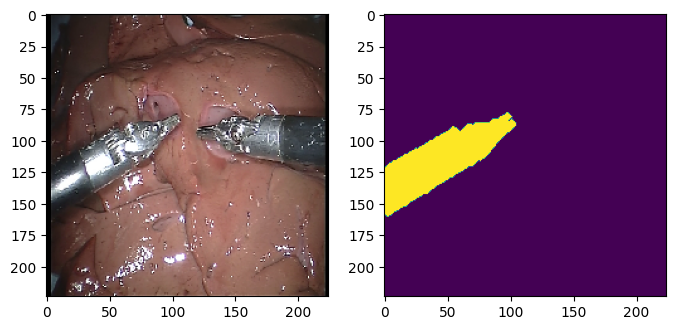

In [ ]:
X,y = train_generator.__getitem__(2)
t = 12

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

In [ ]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

4

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y

def Unet(h, w, filters):
    # Input
    input_layer = Input(shape=(h, w, 3), name='image_input')

    # Down
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.1)(conv4_out)

    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.1)(conv5)

    # Up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.1)(deconv6)

    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.1)(deconv7)

    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)

    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)

    # Output
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model


In [ ]:
model = Unet(224 , 224 , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_90 (Ba  (None, 224, 224, 64)         256       ['conv2d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 224, 224, 64)         0         ['batch_normalization_90[0]

In [ ]:
def jaccard_distance_loss(y_true, y_pred,smooth = 5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
optimizer = tf.keras.optimizers.Adamax()

In [ ]:
model.compile(optimizer=optimizer, loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = []
model.metrics_names

[]

In [ ]:
results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=5,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

<ipython-input-85-023b50aad1ad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=5,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)
<ipython-input-8-98b18ab2b072>:44: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-8-98b18ab2b072>:45: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/5
26/26 [==============================] - 77s 3s/step - loss: 0.0952 - dice_coef: 0.6138 - accuracy: 0.9551 - val_loss: 0.7695 - val_dice_coef: 0.1422 - val_accuracy: 0.0766
Epoch 2/5
26/26 [==============================] - 67s 3s/step - loss: 0.0316 - dice_coef: 0.8131 - accuracy: 0.9929 - val_loss: 0.5972 - val_dice_coef: 0.1787 - val_accuracy: 0.3262
Epoch 3/5
26/26 [==============================] - 67s 3s/step - loss: 0.0241 - dice_coef: 0.8517 - accuracy: 0.9944 - val_loss: 0.1304 - val_dice_coef: 0.5257 - val_accuracy: 0.9704
Epoch 4/5
26/26 [==============================] - 67s 3s/step - loss: 0.0204 - dice_coef: 0.8718 - accuracy: 0.9945 - val_loss: 0.0596 - val_dice_coef: 0.7041 - val_accuracy: 0.9916
Epoch 5/5
26/26 [==============================] - 67s 3s/step - loss: 0.0173 - dice_coef: 0.8891 - accuracy: 0.9952 - val_loss: 0.0492 - val_dice_coef: 0.6811 - val_accuracy: 0.9793


In [ ]:
loss = results.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results.history["accuracy"]
# val_acc = results.history["val_accuracy"]

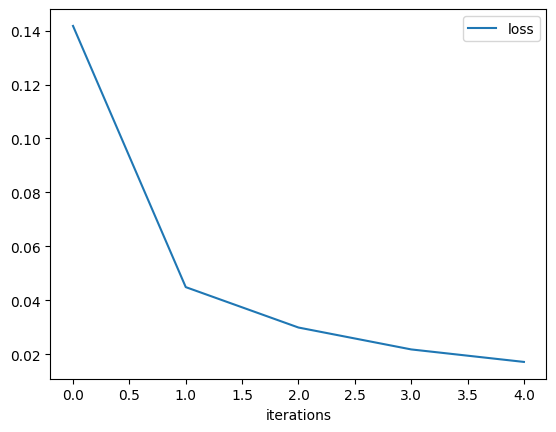

In [ ]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

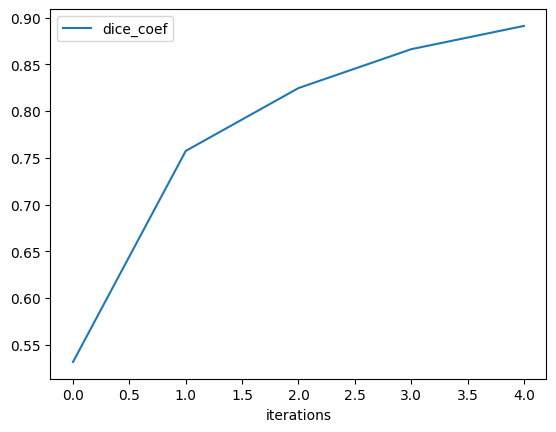

In [ ]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

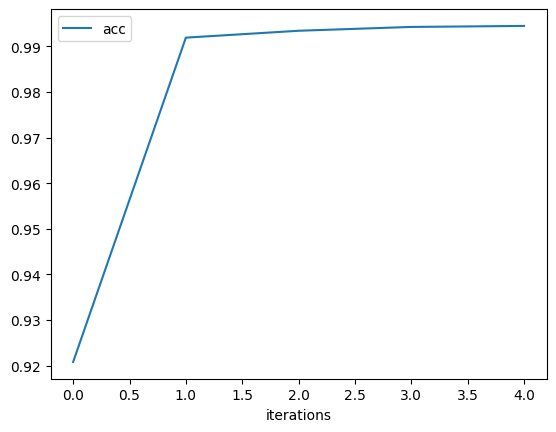

In [ ]:
plt.plot(acc,label = "acc")
plt.xlabel("iterations")
plt.legend()

In [6]:
def make_prediction(model,image,shape):
    #img = img_to_array(load_img(image,target_size=shape))
    img=image
    img=cv2.resize(img,(shape[1],shape[0]))

    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = (mask[0] > 0.5)*1
#     print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask

(576, 720, 3)

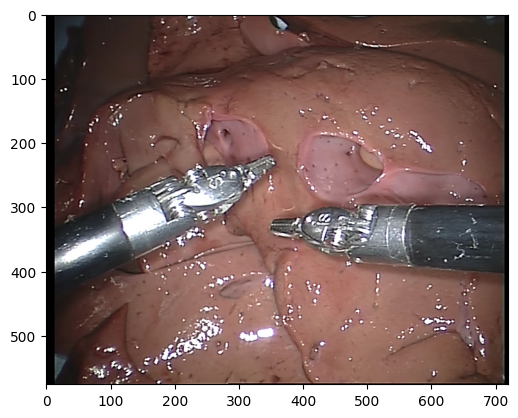

In [ ]:
image = "/content/drive/MyDrive/train_frame/Dataset1/Video/0.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 4s 4s/step
(576, 720, 3) (224, 224, 3)


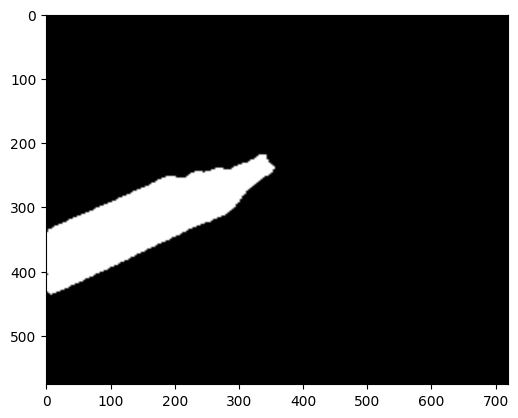

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]


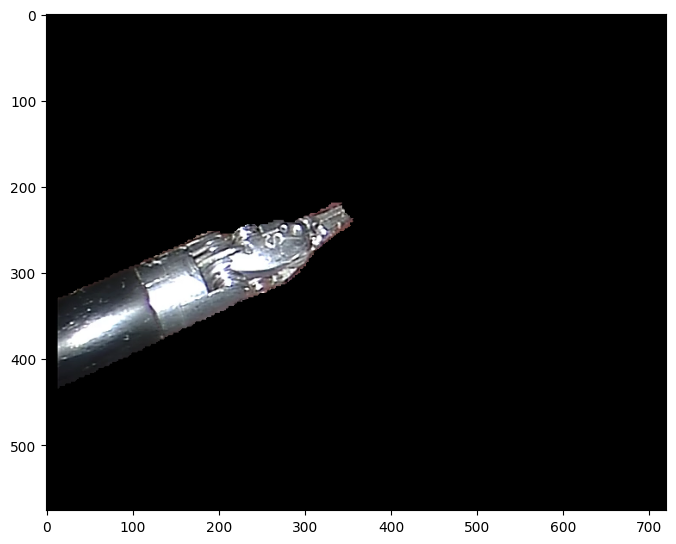

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


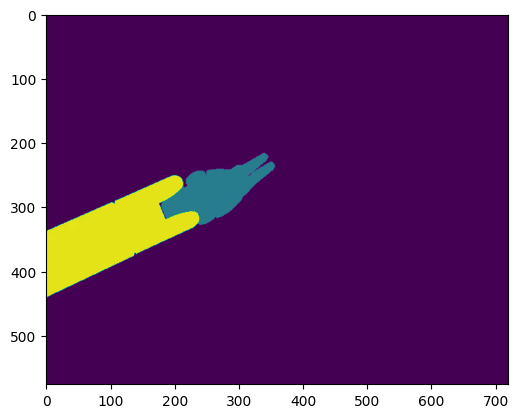

In [ ]:
# prompt: iou with mask and prediction
path= "/content/drive/MyDrive/train_frame/Dataset1/Left_Instrument_Segmentation/0.png"

test = img_to_array(load_img(path,(224,224,3)))
plt.imshow(test)




In [ ]:
print(segment.shape)
import numpy as np
iou = np.sum(np.logical_and(test,segment)) / np.sum(np.logical_or(test,segment))
print(iou)

(576, 720, 3)
0.9107884259160687


In [ ]:
model.save('/content/drive/MyDrive/train_frame_1/modeln.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/train_frame_1/my_model_weights.h5')

In [ ]:
model.save('/content/drive/MyDrive/train_frame_1/my_model.keras')

In [ ]:
model.load_weights('/content/drive/MyDrive/train_frame_1/my_model_weights.h5')

NameError: name 'model' is not defined

In [4]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/drive/MyDrive/train_frame_1/modelnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/train_frame_1/modeln.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
model=loaded_model

In [ ]:
path = '/content/drive/MyDrive/train_frame_1/test_frames/Video/'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame_1/test_frames/pix_test/{}'.format(f))

In [ ]:
path = '/content/drive/MyDrive/train_frame_1/test_frames/Left_Surgical_Instruments/Left_Instrument_Segmentation'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame_1/test_frames/pix_mask/{}'.format(f))

In [8]:
test_folder = "/content/drive/MyDrive/train_frame_1/test_frames/Video"

# List to store test images
test_images = []

# Iterate over files in the folder
for filename in os.listdir(test_folder):
    # Check if the file is an image (you may want to add more checks here)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Open the image file
        image_path = os.path.join(test_folder, filename)
        image = Image.open(image_path)
        # You may need to resize or preprocess the image here depending on your model
        # For example, you can resize the image to a specific size:
        # image = image.resize((width, height))
        # Append the image to the list
        test_images.append(image)

In [9]:
mask_folder='/content/drive/MyDrive/train_frame_1/test_frames/Left_Surgical_Instruments/Left_Instrument_Segmentation'
mask_images = []
for filename in os.listdir(mask_folder):
    if filename.endswith(".png"):
        image_path = os.path.join(mask_folder, filename)
        image = Image.open(image_path)
        mask_images.append(image)

1/1 [==============================] - 2s 2s/step


0.059238404400928237
1/1 [==============================] - 1s 1s/step


0.0592084283907312
1/1 [==============================] - 1s 1s/step


0.05924331848598037
1/1 [==============================] - 1s 1s/step


0.05923308109224516


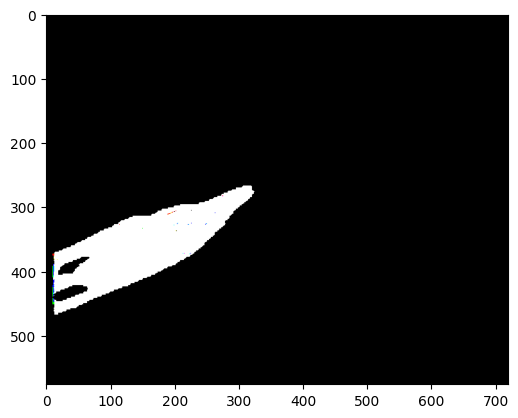

In [ ]:
for i in [1, 2, 3, 4]:
  #im_dir= "/content/drive/MyDrive/train_frame_1/test_frames/Video"
  path="/content/drive/MyDrive/train_frame_1/test_frames/Video/100.png"

  #img = img_to_array(load_img(path))
  img=np.array(test_images[i*10])
  plt.imshow(img/255.)

  mask = make_prediction(model,path,(224,224,3))
  mask2 = cv2.merge([mask,mask,mask]).astype('float32')
  mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
  h,w = img.shape[:2]
  mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
  mask_resized = mask_resized != 0
  segment = np.zeros((h,w,3))
  segment[:,:,0] = img[:,:,0]*mask_resized
  segment[:,:,1] = img[:,:,1]*mask_resized
  segment[:,:,2] = img[:,:,2]*mask_resized
  segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
  #test_dir= "/content/drive/MyDrive/train_frame_1/test_frames/Video"
  #path=os.path.join(test_dir,'1.png')
  #path= "/content/drive/MyDrive/train_frame_1/test_frames/Left_Surgical_Instruments/Left_Instrument_Segmentation/100.png"
  #test = img_to_array(load_img(path,(224,224,3)))
  actual=np.array(mask_images[i*10])
  plt.imshow(segment)

  iou = np.sum(np.logical_and(actual,segment)) / np.sum(np.logical_or(actual,segment))
  print(iou)

In [ ]:
np.array(test_images[1]).shape

(576, 720, 3)

In [7]:
iou=[]
dice=[]
for i in range(len(test_images)):
  #img=np.array(test_images[i])
  path="/content/drive/MyDrive/train_frame_1/test_frames/Video/" + str(i) +".png"
  print(path)
  img = img_to_array(load_img(path))
  img=np.array(img)
  mask = make_prediction(model,img,(224,224,3))
  mask2 = cv2.merge([mask,mask,mask]).astype('float32')
  mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
  h,w = img.shape[:2]
  mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
  mask_resized1 = cv2.resize(np.uint8(mask*1),(w,h))
  mask_resized = mask_resized != 0
  segment = np.zeros((h,w,3))
  segment[:,:,0] = img[:,:,0]*mask_resized
  segment[:,:,1] = img[:,:,1]*mask_resized
  segment[:,:,2] = img[:,:,2]*mask_resized
  segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
  path= "/content/drive/MyDrive/train_frame_1/test_frames/Left_Surgical_Instruments/Left_Instrument_Segmentation/"+ str(i) +".png"
  actual = img_to_array(load_img(path,(224,224,3)))
  iou_i = np.sum(np.logical_and(actual,segment)) / np.sum(np.logical_or(actual,segment))
  dice_i=2*np.sum(np.logical_and(actual,segment))/(np.sum(np.logical_or(actual,segment))+np.sum(np.logical_and(actual,segment)))
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))
  ax1.set_title("Input Image")
  ax1.imshow(img/255.)
  ax2.set_title("True Mask")
  ax2.imshow(actual)
  ax3.set_title("Predicted mask with IOU score %.2f"%(iou_i))
  ax3.imshow(segment)
  plt.show()
  iou.append(iou_i)
  dice.append(dice_i)
  print(dice_i)

NameError: name 'test_images' is not defined

In [10]:
iou=[]
dice=[]
for i in range(len(test_images)):
  #img=np.array(test_images[i])
  path="/content/drive/MyDrive/train_frame_1/test_frames/Video/" + str(i) +".png"
  print(path)
  img = img_to_array(load_img(path))
  img=np.array(img)
  mask = make_prediction(model,img,(224,224,3))
  mask2 = cv2.merge([mask,mask,mask]).astype('float32')
  mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
  h,w = img.shape[:2]
  mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
  mask_resized1 = cv2.resize(np.uint8(mask*1),(w,h))
  mask_resized = mask_resized != 0
  segment = np.zeros((h,w,3))
  segment[:,:,0] = img[:,:,0]*mask_resized
  segment[:,:,1] = img[:,:,1]*mask_resized
  segment[:,:,2] = img[:,:,2]*mask_resized
  segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
  path= "/content/drive/MyDrive/train_frame_1/test_frames/Left_Surgical_Instruments/Left_Instrument_Segmentation/"+ str(i) +".png"
  actual = img_to_array(load_img(path,(224,224,3)))
  iou_i = np.sum(np.logical_and(actual,segment)) / np.sum(np.logical_or(actual,segment))
  dice_i=2*np.sum(np.logical_and(actual,segment))/(np.sum(np.logical_or(actual,segment))+np.sum(np.logical_and(actual,segment)))
  iou.append(iou_i)
  dice.append(dice_i)
  print(dice_i)

/content/drive/MyDrive/train_frame_1/test_frames/Video/0.png
1/1 [==============================] - 4s 4s/step
0.9450564176784326
/content/drive/MyDrive/train_frame_1/test_frames/Video/1.png
1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


0.9451193630396805
/content/drive/MyDrive/train_frame_1/test_frames/Video/2.png
1/1 [==============================] - 0s 21ms/step
0.9435427812882596
/content/drive/MyDrive/train_frame_1/test_frames/Video/3.png
1/1 [==============================] - 0s 20ms/step
0.9432682258820138
/content/drive/MyDrive/train_frame_1/test_frames/Video/4.png
1/1 [==============================] - 0s 19ms/step
0.9404974639446941
/content/drive/MyDrive/train_frame_1/test_frames/Video/5.png
1/1 [==============================] - 0s 20ms/step
0.9404504614715438
/content/drive/MyDrive/train_frame_1/test_frames/Video/6.png
1/1 [==============================] - 0s 19ms/step
0.9405665298346676
/content/drive/MyDrive/train_frame_1/test_frames/Video/7.png
1/1 [==============================] - 0s 20ms/step
0.9406817336393907
/content/drive/MyDrive/train_frame_1/test_frames/Video/8.png
1/1 [==============================] - 0s 19ms/step
0.9416157193339451
/content/drive/MyDrive/train_frame_1/test_frames/Video/9.

In [11]:
iou=np.array(iou)
dice=np.array(dice)

In [12]:
print(dice)

[0.94505642 0.94511936 0.94354278 0.94326823 0.94049746 0.94045046
 0.94056653 0.94068173 0.94161572 0.94229257 0.94208392 0.94183223
 0.94106682 0.94031704 0.94099296 0.94140028 0.94072067 0.94122684
 0.94006338 0.93919577 0.93963884 0.93871399 0.93839006 0.93874707
 0.93817982 0.93791871 0.93682546 0.93790077 0.93668268 0.93459673
 0.93447514 0.93473876 0.93284119 0.93394984 0.9324654  0.93588339
 0.93616522 0.93794463 0.9279803  0.92442433 0.92081762 0.90958837
 0.90835216 0.9019575  0.88901444 0.88378508 0.87600283 0.87798797
 0.87277833 0.88476951 0.89039308 0.89747801 0.89271823 0.90653768
 0.91298464 0.9103449  0.90650207 0.89456957 0.88856189 0.88599352
 0.88105832 0.88636815 0.88853964 0.86571298 0.85029482 0.86753324
 0.86795059 0.87038788 0.87671915 0.87626566 0.88088721 0.88107778
 0.88272447 0.88290365 0.88950995 0.88587209 0.888545   0.88853286
 0.8874379  0.88807253 0.88537925 0.87402925 0.87527506 0.87889933
 0.87439349 0.88618562 0.86435367 0.86748769 0.87645285 0.8826

In [14]:
dice.mean()

0.8751413849539109

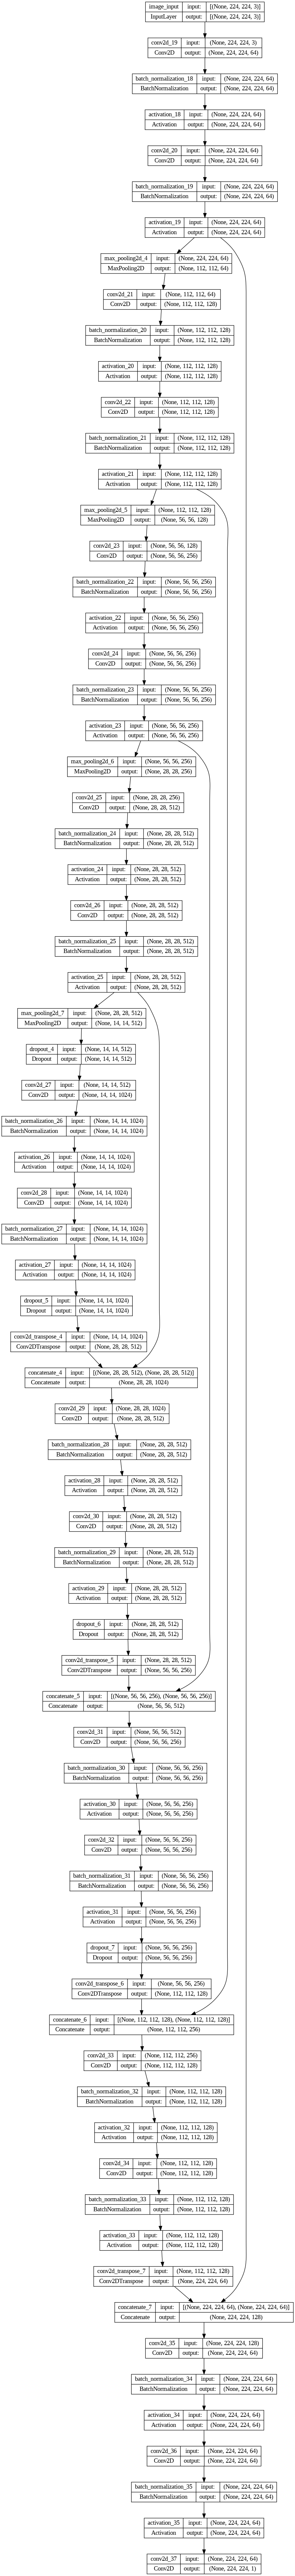

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/train_frame_1/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
np.max(img_gray)

255.0

In [ ]:
np.sum(img_gray)

4619297.0

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
segment.shape

(576, 720, 3)

In [ ]:
x=np.array(mask_resized == 'true',dtype=int)

In [ ]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])